# **SPICED ACADEMY  //  WEEK 07  //  TEMPERATURE FORECASTING**
**Brunno Gorgulho Soares**

---

# 0. Set Up

## 0.a. Modules

In [1]:
# Essentials
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plt.rcParams['figure.figsize'] = (18, 4)

# Feature Engineering
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Modelling
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# Hyperparameter Optimization
from sklearn.model_selection import TimeSeriesSplit

# Testing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Ignore future warnings
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category='SettingWithCopyWarning')

## 0.b. Helpers

Plotting control for workflow efficiency

In [2]:
plot = True

---

# 1. Business Goal
Accurately predict a day's average temperature in Tempelhof, Berlin, Germany one day ahead.

Approach:
Past weather data is used to train the model. I separate signal into three parts: trend, seasonality and remainder. Trend is estimated using a univariate OLS linear regression, and monthly seasonality is one-hot encoded into dummy columns. Remainder contains signal and white noise, which I disect using AR and ARIMA techniques. Noise is confirmed to be white noise by analyzing leftover residual properties: mean and covariance of zero, and homoskedasticity. 

Note: when I refer to future, that means a point in time after the end date of the dataset.


---

# 2. Get Data

The temperature data comes from www.ecad.eu, and is mean daily temperature in Berlin-Tempelhof over several decades. The original data is in 0.1 degrees celsius, and I convert to degrees celsius by dividing temperature by 10. 

In [3]:
df = pd.read_csv('data/TG_STAID002759.csv', na_values='-9999', parse_dates=['date'], index_col=['date'])
df = df.drop(['souid','q_tg'], axis=1)
df['tg'] = df['tg'] / 10

---

# 3. Train-Test Split

## 3.a. Removing NAs before Train-Test Splitting

As rows are not randomly assigned to train or test, NAs are checked before splitting.

In [4]:
print(df.index.min().date(), df.index.max().date())
print(df['tg'].isna().sum())

# Lowest date value for NA is 1945-04-25 and highest 1945-11-05
df_nas = df[df['tg'].isna()==True].index
print(df_nas.min(), df_nas.max())

# Imputing a large number of consecutive data points will not be trivial, therefore data prior to 1946 is dropped
df = df[df.index>='1946-01-01']

# Double-checking for 0 NAs, and it is true
print(df['tg'].isna().sum())

1876-01-01 2021-09-30
195
1945-04-25 00:00:00 1945-11-05 00:00:00
0


## 3.b. Train-Test Splitting Remaining Rows

Below, I develop a method for splitting the dataset into Train and Test sub-sets which is rubust with an updated version of the temperature dataset and where no individual date is over-represented.  To avoid over-representation of any particular date, I enforce that both sub-sets have n complete 12-month periods, and 0 partial 12-month periods.

In [6]:
# Define start and end dates for full dataset
end_date_month = df.index.max().month
end_date_day = df.index.max().day
start_date = pd.to_datetime(f'{df.index.min().year}-{end_date_month}-{end_date_day}') + pd.Timedelta('1 day')
end_date = df.index.max()
print(start_date.date(), end_date.date())
assert type(start_date) == type(end_date)

# Define split index and year
split_nearest_index = int(df['tg'].groupby(df.index.year).count().sum() * (4/5))
split_year = df.index[split_nearest_index].year
print('Split index:', split_nearest_index, 'Split year:', split_year)

# Define start and end dates for train and test sub-sets
train_start_date = start_date
train_end_date = pd.to_datetime(f'{split_year}-{end_date_month}-{end_date_day}')

test_start_date = pd.to_datetime(f'{split_year}-{end_date_month}-{end_date_day}') + pd.Timedelta('1 day')
test_end_date = end_date

# Split dataset into sub-sets
df_train = df[(df.index >= train_start_date) & (df.index <= train_end_date)]
df_test = df[(df.index >= test_start_date) & (df.index <= test_end_date)]

# Print sub-sets start and end dates for reivew
print('Train starts:', df_train.index.min().date(), 'Train ends:', df_train.index.max().date())
print('Test starts:', df_test.index.min().date(), 'Test ends :', df_test.index.max().date())

1946-10-01 2021-09-30
Split index: 22133 Split year: 2006
Train starts: 1946-10-01 Train ends: 2006-09-30
Test starts: 2006-10-01 Test ends : 2021-09-30


---

# 4. Explore Data

'tg' is the temperature in degrees celsius.

In [7]:
df_train.head()

,tg
date,
1946-10-01,11.0
1946-10-02,9.5
1946-10-03,8.2
1946-10-04,9.6
1946-10-05,10.2


Visually, temperature data appears to be a weakly stationary process.

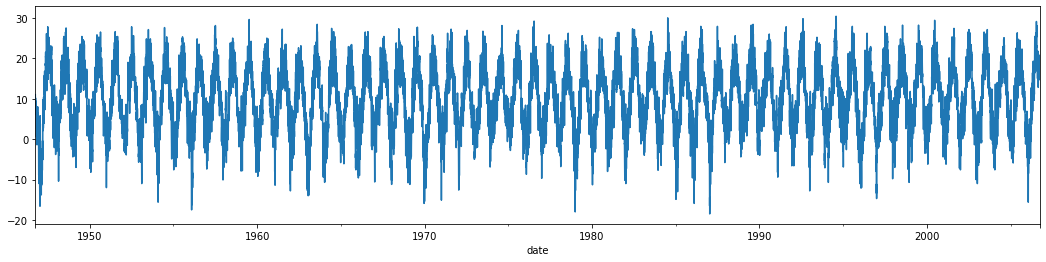

In [8]:
if plot: df_train['tg'].plot()

Monthly seasonality can be clearly observed.

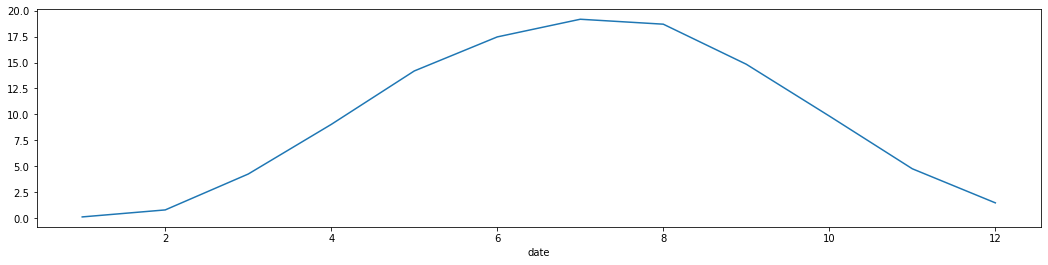

In [9]:
if plot: df_train['tg'].groupby(df_train.index.month).mean().plot()

There appears to be some element of randomness in the mean yearly temperature, and possibly an upward trend. This will be looked into. Data for the first and last years do not represent complete years, as the train sub-set ranges from 1946-10-01 until 2006-09-3.

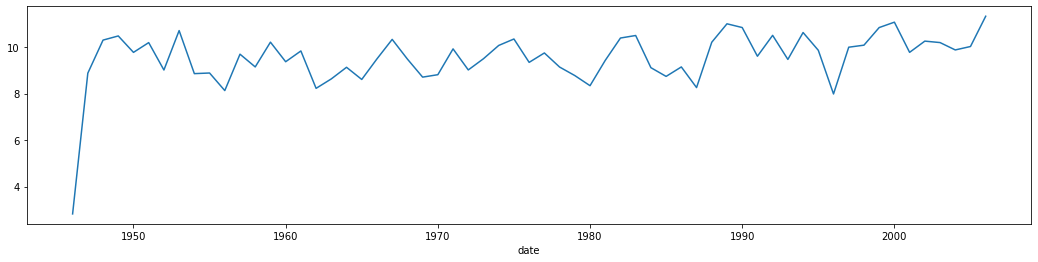

In [10]:
if plot: df_train['tg'].groupby(df_train.index.year).mean().plot()

---

# 5. Feature Engineering

## 5.a. Execution

Below I define all functions to be used in the Feature Engineering pipeline.

In [12]:
def timestep_detrend(df):

    ''' Sub-function to remove_seasonal_trend. Adds timestamp column for trend modelling. '''

    df['timestep'] = list(range(len(df)))
    return df



def ohe_deseasonal(df, season_granularity):
 
    ''' Sub-function to remove_seasonal_trend. Adds one-hot encoded columns for seasonality modelling. '''
    
    if season_granularity=='month':
        df_month = pd.get_dummies(data=df.index.month, drop_first=True, prefix='month').set_index(df.index)
        df = df.join(df_month)

    elif season_granularity=='weeknum':
        df_weeknum = pd.get_dummies(data=df.index.weekofyear, drop_first=True, prefix='weeknum').set_index(df.index)
        df = df.join(df_weeknum)

    else:
        raise Exception('Try one of: month, weeknum in ohe_deseasonal function.')

    return df



def remove_trend_seasonal(df, season_granularity='month'):

    ''' Creates new y column removing trend and seasonality. '''
    
    df = timestep_detrend(df) # timestamp column helps de-trending
    df = ohe_deseasonal(df, season_granularity) # one-hot encoded seasonal columns help de-seasonalization
    
    X = df.drop(['tg'], axis=1)
    y = df['tg']

    m1 = LinearRegression()
    m1.fit(X, y)
    df['trend_seasonal'] = m1.predict(X)

    df['remainder'] = df['tg'] - df['trend_seasonal']

    return df



def lag(df, n=4):

    ''' Creates lag functions for lags 1 to n. Drops NAs '''
    
    for iter in range(1,n+1):
        df[f'remainder_lag{iter}'] = df['remainder'].shift(iter)
    
    df = df.dropna() # Drops NAs generated through lags.

    return df



def drop_cols(df):

    ''' Drops intermediary columns (after calculation of another column). '''

    df = df.drop(['trend_seasonal','remainder'], axis=1)
    return df

Below, I build the Feature Engineering pipeline applying the above-defined functions.

In [13]:
# Call functions
get_no_trend_seasonal = FunctionTransformer(remove_trend_seasonal)
get_lags = FunctionTransformer(lag)
get_drop_cols = FunctionTransformer(drop_cols)

# Define pipeline
pipe_model_month = Pipeline([
    ('get_no_trend_seasonal', get_no_trend_seasonal),
    ('get_lags', get_lags),
    ('get_drop_cols', get_drop_cols)
])

# Fit pipeline using df_train and transform df_train
df_train_model = pipe_model_month.fit_transform(df_train)
X_train_model = df_train_model.drop(['tg'], axis=1)
y_train_model = df_train_model['tg']

# Transform test dataset
df_test_model = pipe_model_month.transform(df_test)
X_test_model = df_test_model.drop(['tg'], axis=1)
y_test_model = df_test_model['tg']

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## 5.b. Feature Engineering Exploration

Below, I build the Feature Engienering for plotting. This pipeline does not drop *remainder* and *trend-seasonal* columns which are useful for plotting.

In [15]:
# Call functions
get_no_trend_seasonal = FunctionTransformer(remove_trend_seasonal)
get_lags = FunctionTransformer(lag)

# Define pipeline
pipe_plot = Pipeline([
    ('get_no_trend_seasonal', get_no_trend_seasonal),
    ('get_lags', get_lags),
])

# Fit pipeline using df_train and transform df_train
df_train_plot = pipe_plot.fit_transform(df_train)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


I check the remainder (signal + noise remaining after de-trending and de-seazonalization) for weak stationarity using the Augmented Dickie Fuller test. I find the remainder to be weakly stationary, and can thus proceed with modelling it.

In [16]:
result = adfuller(df_train_plot['remainder'])
print('ADF statistic:', result[0])
print('p-value:', result[1])

ADF statistic: -20.87786246079486
p-value: 0.0


I test for whether an Autocorrelation or Moving Average model (or a combination, ARIMA) best fits this problem.  I observe a clear partial correlation cutoff (from lag1 to lag2) and no autocorrelation cutoff.  The conclusion is that an AR model best serves this problem. I use AR as a reference point, and then apply ARIMA to compare the results (both in Train and Test sub-sets).

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


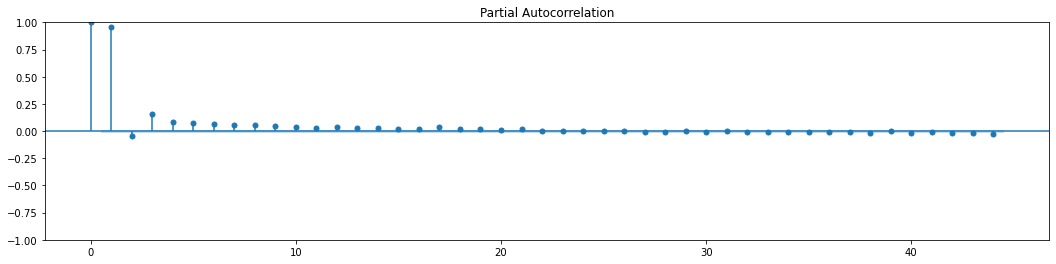

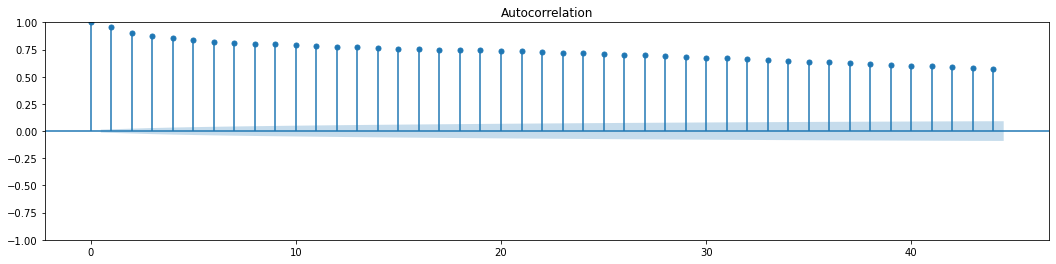

In [17]:
if plot: 
    plot_pacf(df_train_plot['tg'])
    plot_acf(df_train_plot['tg'])

In [18]:
''' Strong correlation between remainder and its lags. ''' 
print(round(df_train_plot[['remainder','remainder_lag1','remainder_lag2','remainder_lag3','remainder_lag4']].corr(), 2))


''' The correlation between lag2 and remainder is fully explained by the indirect effect of lag2 through lag1. Why keep lag2? '''  
remainder_lag1_corr = 0.8
lag1_lag2_corr = 0.8
remainder_lag2_corr = 0.6
print('Partial_autocorrelation:', remainder_lag2_corr - (remainder_lag1_corr * lag1_lag2_corr)) # WHAT'S GOING ON HERE? 

                remainder  remainder_lag1  remainder_lag2  remainder_lag3  \
remainder            1.00            0.80             0.6            0.47   
remainder_lag1       0.80            1.00             0.8            0.60   
remainder_lag2       0.60            0.80             1.0            0.80   
remainder_lag3       0.47            0.60             0.8            1.00   
remainder_lag4       0.37            0.47             0.6            0.80   

                remainder_lag4  
remainder                 0.37  
remainder_lag1            0.47  
remainder_lag2            0.60  
remainder_lag3            0.80  
remainder_lag4            1.00  
Partial_autocorrelation: -0.04000000000000015


---

# 6: Train Model

## 6 a: Linear Regression

I train a multivariate linear regression, modelled as follows:

$ y_t = \beta_{0} + \beta_{1} X_{timestep,\ t} + \beta_{2} X_{Feb\_dummy,\ t} + ... + \beta_{12} X_{Dec\_dummy,\ t} + \beta_{13} X_{R,\ t-1} + \beta_{14} X_{R,\ t-2} + \beta_{15} X_{R, t-3} + \beta_{16} X_{R, t-4} + \epsilon_{t} $ 

Where $ y_{t} $ is temperature in degrees celsius, $ X_{timestep} $ is the timestep value (linearized datetime), $ X_{Feb\_dummy} $ to $ X_{Dec\_dummy} $ are month one-hot encoded dummies, and $ X_{R, t-n} $ are the lags of the remainder (signal leftover after de-trending and de-seasonalizing).

In [19]:
m2 = LinearRegression()
m2.fit(X_train_model, y_train_model)
print('M2 R2:', round(m2.score(X_train_model, y_train_model),2))
print(pd.DataFrame({'parameter':X_train_model.columns, 'coefficient':m2.coef_}))
print(f'Model intercept: {round(m2.intercept_, 2)}')
print(f'Each year temperature increases by roughly: {round(m2.coef_[0] * 365, 2)} degrees celsius.')

M2 R2: 0.91
         parameter  coefficient
0         timestep     0.000037
1          month_2     0.672812
2          month_3     4.144789
3          month_4     8.878067
4          month_5    13.994699
5          month_6    17.294469
6          month_7    19.027243
7          month_8    18.466908
8          month_9    14.659410
9         month_10     9.677570
10        month_11     4.632498
11        month_12     1.327569
12  remainder_lag1     0.912501
13  remainder_lag2    -0.184523
14  remainder_lag3     0.051057
15  remainder_lag4     0.018868
Model intercept: -0.25
Each year temperature increases by roughly: 0.01 degrees celsius.


<AxesSubplot:xlabel='date'>

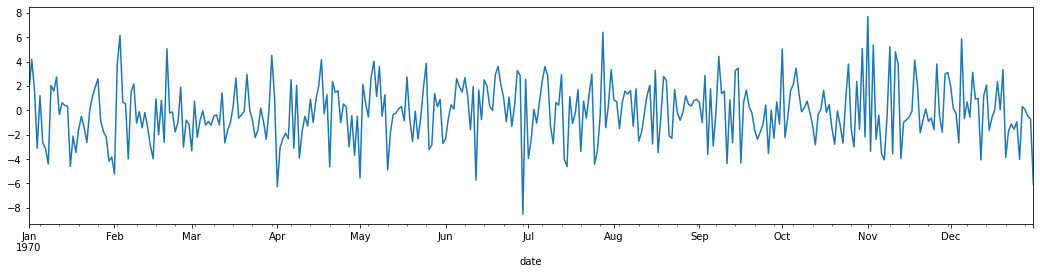

In [20]:
residuals_m2 = y_train_model - m2.predict(X_train_model)
residuals_m2[residuals_m2.index.year==1970].plot()


<AxesSubplot:ylabel='Density'>

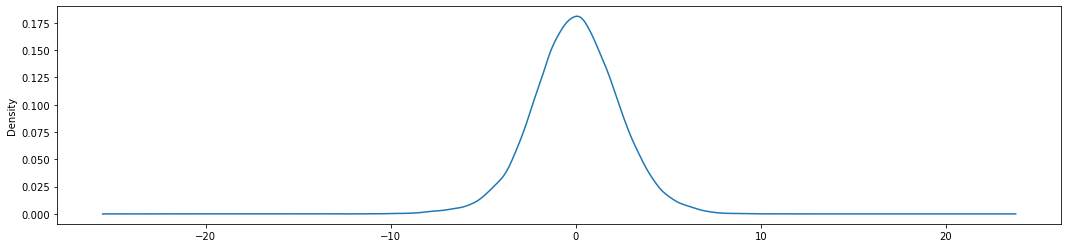

In [21]:
residuals_m2.plot(kind='kde')

I find that the mean is virtually 0 and the covariance between residual and its lag is very insignificant (0.00046).  This indicates that the residual is white noise and no signal remains to be modelled.

In [22]:
print(f'Residual mean: {residuals_m2.mean()}')
print(f'Residual/lag covariance: {np.cov(residuals_m2[:-1], residuals_m2[1:])[0,1]}')

Residual mean: -9.716414914979692e-16
Residual/lag covariance: 0.0004618754928677431


---

# 6 b: ARIMA

In [23]:
df_train_arima, df_test_arima = pd.Series(df_train['tg']), pd.Series(df_test['tg'])

In [ ]:
m4 = ARIMA(df_train_arima, order=(4,1,1), freq='D').fit()
print(f'M4 R2: {round(r2_score(df_train_arima, m4.predict()), 2)}')
m4.summary()

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


M4 R2: 0.92


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     tg   No. Observations:                21915
Model:                 ARIMA(4, 1, 1)   Log Likelihood              -49514.094
Date:                Sun, 05 Dec 2021   AIC                          99040.189
Time:                        22:45:03   BIC                          99088.158
Sample:                    10-01-1946   HQIC                         99055.814
                         - 09-30-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8511      0.010     82.028      0.000       0.831       0.871
ar.L2         -0.1985      0.008    -24.098      0.000      -0.215      -0.182
ar.L3          0.0465      0.009      5.404      0.000       0.030       0.063
ar.L4         -0.0047      0.007     -0.657      0.511      -0.019       0.009
ma.L1         -0.8846      0.008   -107.725      0.000      -0.901      -0.869
sigma2         5.3712      0.045    119.667      0.000       5.283       5.459
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               526.49
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.07
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:ylabel='Density'>

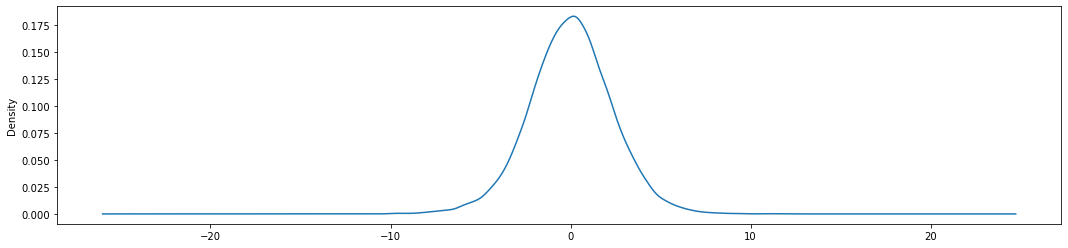

In [ ]:
m4.resid.plot(kind='kde')

In [ ]:
# define an evaluate models function

def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [27]:
p_values = range(0, 1)
d_values = range(0, 1)
q_values = range(0, 1)

evaluate_models(df_train_arima.values, p_values, d_values, q_values)

---

# 7. Hyperparameter Optimization // Cross-Validation

I check which degrees of remainder lag to include using Akaike Information Criterion.  The result is 4 degrees, which I adjust the model with.

In [ ]:
if plot: selected_order = ar_select_order(df_train_plot['remainder'], ic='aic', maxlag=20)
selected_order.ar_lags

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


[1, 2, 3, 4]

---

# 8. Calculate Test Score

I compare the $ R^2 $ for train and test sub-sets and find a slight overfit.  Nothing major.

In [ ]:
print('Train R2:', round(m2.score(X_train_model, y_train_model), 2), '\nTest R2:', round(m2.score(X_test_model, y_test_model), 2))

Train R2: 0.91 
Test R2: 0.88


---

# 9. Deploy & Monitor

In [ ]:
# Fit pipeline using df_train and transform df_train
df_full_predict = pipe_plot.fit_transform(df)
X_full_predict = df_full_predict.drop(['tg','trend_seasonal','remainder'], axis=1)
y_full_predict = df_full_predict['tg']

I build X values for the future in order to predict future weather.  It must include the following columns:
['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'remainder_lag1', 'remainder_lag2', 'remainder_lag3', 'remainder_lag4']

In [ ]:
# Define date to predict
future_date = df_full_predict.index.max() + pd.to_timedelta('1 day') 
print(future_date)

# Timestep
print('Max timestep test set:', df_full_predict['timestep'].max())
future_timestamp = df_full_predict['timestep'].max() + 1 # future timestamp

# Month values, one-hot encoded
future_ohe_months = [0 for n in range(11)]
future_ohe_months[future_date.month - 2] = 1 # future ohe_months; -2 is -1 due to python starting at 0 and another -1 due to dropped jan column
print(future_ohe_months)

# Remainder lag
future_lags = [df_full_predict['remainder'][-1], df_full_predict['remainder'][-2], df_full_predict['remainder'][-3], df_full_predict['remainder'][-4]] # lags
print(future_lags)

# Concatenate above parts into list
X_future = [future_timestamp] + (future_ohe_months) + (future_lags)
X_future = np.reshape(X_future, (1,-1))
X_future = pd.DataFrame(X_future, columns=[X_train_model.columns])

2021-10-01 00:00:00
Max timestep test set: 27666
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[-4.122147430768111, -1.9220856182627237, -0.12202380575733507, 2.178038006748052]


In [29]:
print(f'The mean temperature on {future_date.date()} is forecasted to be {round(m2.predict(X_future)[0], 1)} C')

The mean temperature on 2021-10-01 is forecasted to be 7.1 C


---

# 10. Appendix

Modelling seasonality with week number rather than month increases the nuance of the model by less than it increases complexity, as I later find a tiny change in $ R^2 $ between the two approaches.

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


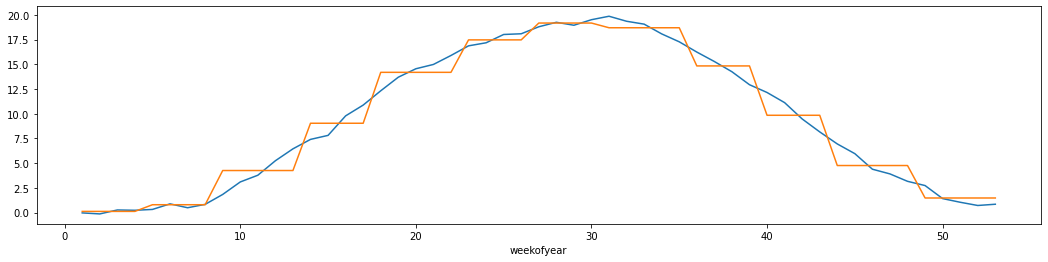

In [30]:
if plot:
    df_plot = df_train.copy()

    df_plot['month'] = df_plot.index.month
    df_plot['weekofyear'] = df_plot.index.weekofyear
    weekofyear_to_month = pd.Series(df_plot['month'].groupby(df_plot['weekofyear']).median())

    seasonality_weekofyear = pd.DataFrame(df_plot['tg'].groupby(df_plot['weekofyear']).mean()).reset_index()
    seasonality_weekofyear['month'] = seasonality_weekofyear['weekofyear'].map(weekofyear_to_month)

    seasonality_month = df_plot['tg'].groupby(df_plot['month']).mean()
    seasonality_weekofyear_month = pd.merge(left=seasonality_weekofyear, right=seasonality_month, how='left', left_on=seasonality_weekofyear['month'], right_on=seasonality_month.index)

    seasonality_weekofyear_month.set_index('weekofyear')['tg_x'].plot()
    seasonality_weekofyear_month.set_index('weekofyear')['tg_y'].plot()

In [31]:
''' Building pipeline for modelling assuming WEEKNUM seasonality. '''

get_no_trend_seasonal = FunctionTransformer(remove_trend_seasonal, kw_args={'season_granularity':'weeknum'})
get_lags = FunctionTransformer(lag)
get_drop_cols = FunctionTransformer(drop_cols)



pipe_model_weeknum = Pipeline([
    ('no_trend_seasonal', get_no_trend_seasonal),
    ('lags', get_lags),
    ('drop_cols', get_drop_cols)
])

In [32]:
''' Transforming Data and Splitting X-y '''

df_train_weeknum = pipe_model_weeknum.fit_transform(df_train)
X_train_weeknum = pipe_model_weeknum.transform(df_train).drop(['tg'], axis=1)
y_train_weeknum = pipe_model_weeknum.transform(df_train)['tg']


''' Checking columns '''
assert list(X_train_weeknum.columns) == ['timestep', 'weeknum_2', 'weeknum_3', 'weeknum_4', 'weeknum_5',
       'weeknum_6', 'weeknum_7', 'weeknum_8', 'weeknum_9', 'weeknum_10',
       'weeknum_11', 'weeknum_12', 'weeknum_13', 'weeknum_14', 'weeknum_15',
       'weeknum_16', 'weeknum_17', 'weeknum_18', 'weeknum_19', 'weeknum_20',
       'weeknum_21', 'weeknum_22', 'weeknum_23', 'weeknum_24', 'weeknum_25',
       'weeknum_26', 'weeknum_27', 'weeknum_28', 'weeknum_29', 'weeknum_30',
       'weeknum_31', 'weeknum_32', 'weeknum_33', 'weeknum_34', 'weeknum_35',
       'weeknum_36', 'weeknum_37', 'weeknum_38', 'weeknum_39', 'weeknum_40',
       'weeknum_41', 'weeknum_42', 'weeknum_43', 'weeknum_44', 'weeknum_45',
       'weeknum_46', 'weeknum_47', 'weeknum_48', 'weeknum_49', 'weeknum_50',
       'weeknum_51', 'weeknum_52', 'weeknum_53', 'remainder_lag1', 
       'remainder_lag2', 'remainder_lag3', 'remainder_lag4']

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [33]:
''' Calling and fitting model. '''

m3 = LinearRegression()
m3.fit(X_train_weeknum, y_train_weeknum)
m3.score(X_train_weeknum, y_train_weeknum)

0.9181723426841264

---

In [34]:
''' This code was used to inspect for chronic under-prediction in peaks and over-prediction in troughs, which is not apparent. '''

# min_year_train = df_train_model.index.min().year
# max_year_train = df_train_model.index.max().year + 1
# if plot:
#     for year in range(min_year_train, max_year_train):
#         df_train_model[ (df_train_model.index >= f'{year}-01-01') & (df_train_model.index <= f'{year}-12-31')][['tg','pred_ar3']].plot(alpha=0.7, title=f'{year}')

' This code was used to inspect for chronic under-prediction in peaks and over-prediction in troughs, which is not apparent. '

In [35]:
!jupyter nbconvert --to html Temperature-Forecast.ipynb

[NbConvertApp] Converting notebook Temperature-Forecast.ipynb to html
[NbConvertApp] Writing 986310 bytes to Temperature-Forecast.html
